In [1]:
import time
import torch
from cibsde import nn, utils
import matplotlib.pyplot as plt
device = torch.device('cuda:0')

In [2]:
dx = 4
t = torch.tensor(1.,device=device)
Dx = torch.tensor(0.5,device=device)
Dy = torch.tensor(1,device=device)
r = torch.tensor([1,1.3,1.6,2],device=device)
a = 0.1
R = 2
N = 100
batch = 512
epoch = 10**4
lr = 5*1e-4

x0 = torch.tensor([0,0,R],device=device)

def data_gen(batch):
    xx = torch.tensor([0,0,1,0,0,1,0,0,1,0,0,1.],device=device).expand([batch,12])
    yy = torch.tensor([0,0,R],device=device).expand([batch,3])
    return xx, yy

def pc(i,x,y):
    if i < N:
        return torch.zeros([batch,1]).to(device)
    else:
        x = x.reshape([batch*dx,3])
        x_polar = utils.polar_corr(x).reshape([batch*dx,2])
        return (x_polar[:,0]<torch.pi/4).reshape([batch,dx]).prod(dim=1,keepdim=True).float()*(y[:,-1:] > r[-1]+a)

def refb(x,y):
    thetab = torch.arccos(r/R/2)
    x = x.reshape([batch*dx,3])
    x_polar = utils.polar_corr(x).reshape([batch,dx,2])
    outx = (x_polar[:,:,0] >= thetab).reshape([batch*dx])
    xb = x_polar.clone()
    xb[:,:,0] = thetab
    xb = utils.euclid_corr(xb.reshape([batch*dx,2]))
    nb = torch.cat([xb[:,:1]*xb[:,2:],xb[:,1:2]*xb[:,2:],-xb[:,:2].norm(dim=1,keepdim=True)**2],dim=1)
    nb = nb / nb.norm(dim=1,keepdim=True)
    outy = (y - x0).norm(dim=1) >= R
    nby = (y - x0) / (y - x0).norm(dim=1,keepdim=True)
    yb = nby*R + x0
    return xb, nb, outx, yb, nby, outy

def hitb(x,y):
    x = x.reshape([batch,dx,3])*r.unsqueeze(-1)
    y = y.reshape([batch,1,3])
    return ((x-y).norm(dim=-1) <= a).sum(dim=1) > 0

def f(t,xt,yt,p,grad_p):
    return torch.zeros([batch,1],device=device)

def mu(t,xt):
    return torch.zeros([batch,3],device=device)

def sigma(t,xt):
    return torch.eye(3,device=device).expand([batch,3,3]).clone()*torch.sqrt(2*Dy)

model = nn.ConstaintIBSDE(
    dx = dx,
    dy = 3,
    t = t,
    f = f,
    mu = mu,
    sigma = sigma,
    Dx = Dx/r**2,
    pc = pc,
    data_gen = data_gen,
    N = N,
    refb = refb,
    hitb = hitb,
    params = True
).to(device)

In [3]:
def train(model, params:dict):
    epoch = params['epoch']
    batch = params['batch']
    lr = params['lr']

    optim = torch.optim.Adam(model.parameters(),lr=lr)
    loss_fun = torch.nn.MSELoss()
    
    loss_values = torch.zeros(epoch)
    res_values = torch.zeros(epoch)
    start = time.time()
    for i in range(epoch):
        model.train()
        optim.zero_grad()
        u_pre, u_rel = model(batch)
        loss = loss_fun(u_pre,u_rel)
        loss.backward()
        optim.step()

        model.eval()
        loss_values[i] = loss.item()
        with torch.no_grad():
            res_values[i] = model.p.res.detach().cpu()
            print('\r%5d/{}|{}{}|{:.2f}s  [Loss: %e, Result: %.6f]'.format(
                epoch,
                "#"*int((i+1)/epoch*50),
                " "*(50-int((i+1)/epoch*50)),
                time.time() - start) %
                (i+1,loss_values[i],res_values[i]), end = ' ', flush=True)
    print("\nTraining has been completed.")
    return loss_values, res_values

In [4]:
train_params = {
    'epoch': epoch,
    'batch': batch,
    'lr': lr
}

loss_value, res_values = train(
    model,
    train_params
)

10000/10000|##################################################|8031.91s  [Loss: 1.945896e-02, Result: 0.035759]  
Training has been completed.


<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
C:\Users\WH\AppData\Local\Temp\ipykernel_61760\297320828.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$p(t=0,x=\hat{x},y=\hat{y})$')


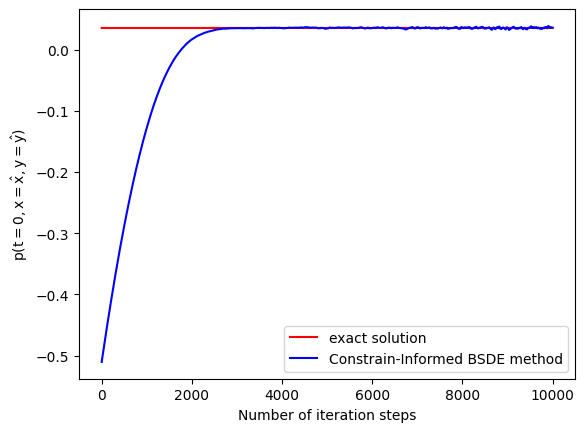

In [6]:
res_rel = 0.035158
plt.xlabel('Number of iteration steps')
plt.ylabel('$p(t=0,x=\hat{x},y=\hat{y})$')
plt.plot(range(10**4),torch.ones(10**4)*res_rel,c='r',label='exact solution')
plt.plot(range(10**4),res_values,c='b',label='Constrain-Informed BSDE method')
plt.legend()
plt.show()